In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
np.random.seed(42)


In [2]:
uk_areas = [
    {"area":"London", "region":"England", "venue":"The O2"},
    {"area":"Manchester", "region":"England", "venue":"AO Arena"},
    {"area":"Birmingham", "region":"England", "venue":"Utilita Arena Birmingham"},
    {"area":"Glasgow", "region":"Scotland", "venue":"OVO Hydro"},
    {"area":"Cardiff", "region":"Wales", "venue":"Utilita Arena Cardiff"},
    {"area":"Belfast", "region":"Northern Ireland", "venue":"SSE Arena Belfast"},
    {"area":"Newcastle", "region":"England", "venue":"Utilita Arena Newcastle"},
    {"area":"Leeds", "region":"England", "venue":"First Direct Arena"},
    {"area":"Liverpool", "region":"England", "venue":"M&S Bank Arena"},
    {"area":"Sheffield", "region":"England", "venue":"Utilita Arena Sheffield"},
    {"area":"Nottingham", "region":"England", "venue":"Motorpoint Arena"},
    {"area":"Bristol", "region":"England", "venue":"Bristol Arena (placeholder)"},
    {"area":"Edinburgh", "region":"Scotland", "venue":"Edinburgh Arena (placeholder)"}
]

venues_df = pd.DataFrame(uk_areas)
venues_df


,area,region,venue
0,London,England,The O2
1,Manchester,England,AO Arena
2,Birmingham,England,Utilita Arena Birmingham
3,Glasgow,Scotland,OVO Hydro
4,Cardiff,Wales,Utilita Arena Cardiff
5,Belfast,Northern Ireland,SSE Arena Belfast
6,Newcastle,England,Utilita Arena Newcastle
7,Leeds,England,First Direct Arena
8,Liverpool,England,M&S Bank Arena
9,Sheffield,England,Utilita Arena Sheffield


In [3]:
def generate_mock_wwe_uk_events(venues_df, n_events=30, start_date="2025-01-01"):
    dates = pd.date_range(start=start_date, periods=n_events, freq="14D")
    chosen = venues_df.sample(n_events, replace=True).reset_index(drop=True)

    events = pd.DataFrame({
        "event_id": [f"UKWWE-{i+1:03d}" for i in range(n_events)],
        "date": dates,
        "area": chosen["area"],
        "region": chosen["region"],
        "venue": chosen["venue"],
        "event_type": np.random.choice(["House Show", "TV Taping", "Premium Live Event (PLE)"], size=n_events, p=[0.70, 0.20, 0.10]),
        "matches_on_card": np.random.randint(6, 13, size=n_events)  # live matches
    })

    # Attendance + pricing assumptions (mock)
    events["attendance"] = np.random.randint(4500, 17000, size=n_events)
    events["avg_ticket_price_gbp"] = np.random.normal(loc=55, scale=12, size=n_events).clip(25, 160).round(2)
    events["merch_per_cap_gbp"] = np.random.normal(loc=12, scale=4, size=n_events).clip(2, 40).round(2)

    # Other revenue streams (mock)
    events["local_sponsorship_gbp"] = np.random.normal(loc=35000, scale=20000, size=n_events).clip(0, 120000).round(0)
    events["concessions_share_gbp"] = np.random.normal(loc=18000, scale=9000, size=n_events).clip(0, 60000).round(0)

    # Costs (mock)
    events["venue_rental_gbp"] = np.random.normal(loc=65000, scale=25000, size=n_events).clip(20000, 160000).round(0)
    events["production_cost_gbp"] = np.random.normal(loc=50000, scale=30000, size=n_events).clip(15000, 250000).round(0)
    events["talent_travel_gbp"] = np.random.normal(loc=35000, scale=12000, size=n_events).clip(8000, 85000).round(0)
    events["local_staffing_gbp"] = np.random.normal(loc=15000, scale=7000, size=n_events).clip(3000, 45000).round(0)
    events["marketing_gbp"] = np.random.normal(loc=12000, scale=6000, size=n_events).clip(1000, 35000).round(0)

    return events

events = generate_mock_wwe_uk_events(venues_df, n_events=36, start_date="2025-01-10")
events.head()


,event_id,date,area,region,venue,event_type,matches_on_card,attendance,avg_ticket_price_gbp,merch_per_cap_gbp,local_sponsorship_gbp,concessions_share_gbp,venue_rental_gbp,production_cost_gbp,talent_travel_gbp,local_staffing_gbp,marketing_gbp
0,UKWWE-001,2025-01-10,Newcastle,England,Utilita Arena Newcastle,House Show,12,8061,56.10,11.23,40010.0,22259.0,82157.0,63315.0,39284.0,14914.0,13345.0
1,UKWWE-002,2025-01-24,Glasgow,Scotland,OVO Hydro,House Show,11,14970,31.15,13.21,41929.0,17345.0,24682.0,73239.0,26685.0,8719.0,12076.0
2,UKWWE-003,2025-02-07,Edinburgh,Scotland,Edinburgh Arena (placeholder),House Show,12,10684,52.36,11.86,21400.0,10379.0,53202.0,22192.0,45795.0,15531.0,12586.0
3,UKWWE-004,2025-02-21,Nottingham,England,Motorpoint Arena,Premium Live Event (PLE),9,7599,59.29,7.33,39645.0,4366.0,92224.0,48214.0,38688.0,10260.0,7362.0
4,UKWWE-005,2025-03-07,Leeds,England,First Direct Arena,House Show,6,10778,72.73,16.57,40861.0,13981.0,66607.0,15000.0,44754.0,21826.0,12147.0


In [4]:
events_fin = events.copy()

# Revenue components
events_fin["ticket_revenue_gbp"] = (events_fin["attendance"] * events_fin["avg_ticket_price_gbp"]).round(2)
events_fin["merch_revenue_gbp"]  = (events_fin["attendance"] * events_fin["merch_per_cap_gbp"]).round(2)

events_fin["total_revenue_gbp"] = (
    events_fin["ticket_revenue_gbp"]
    + events_fin["merch_revenue_gbp"]
    + events_fin["local_sponsorship_gbp"]
    + events_fin["concessions_share_gbp"]
).round(2)

# Cost components
events_fin["total_cost_gbp"] = (
    events_fin["venue_rental_gbp"]
    + events_fin["production_cost_gbp"]
    + events_fin["talent_travel_gbp"]
    + events_fin["local_staffing_gbp"]
    + events_fin["marketing_gbp"]
).round(2)

# Profitability
events_fin["net_profit_gbp"] = (events_fin["total_revenue_gbp"] - events_fin["total_cost_gbp"]).round(2)
events_fin["net_margin_pct"] = (100 * events_fin["net_profit_gbp"] / events_fin["total_revenue_gbp"]).replace([np.inf, -np.inf], np.nan).round(2)

# Simple cash-flow proxy:
# Assume some costs paid immediately; ticket & merch settle quickly; sponsorship may be delayed.
events_fin["cash_in_gbp"] = (events_fin["ticket_revenue_gbp"] + events_fin["merch_revenue_gbp"] + 0.6*events_fin["local_sponsorship_gbp"] + events_fin["concessions_share_gbp"]).round(2)
events_fin["cash_out_gbp"] = (0.8*events_fin["total_cost_gbp"]).round(2)  # assume 80% immediate cash out
events_fin["operating_cash_flow_gbp"] = (events_fin["cash_in_gbp"] - events_fin["cash_out_gbp"]).round(2)

# Balance sheet proxy per event (current assets vs current liabilities)
events_fin["current_assets_gbp"] = (np.random.normal(120000, 40000, size=len(events_fin)).clip(20000, 300000)).round(0)
events_fin["current_liabilities_gbp"] = (np.random.normal(80000, 35000, size=len(events_fin)).clip(10000, 250000)).round(0)
events_fin["current_ratio"] = (events_fin["current_assets_gbp"] / events_fin["current_liabilities_gbp"]).round(2)

# Recurring revenue proxy: count repeat events per area
events_fin["events_in_area_this_year"] = events_fin.groupby(events_fin["area"])["event_id"].transform("count")
events_fin["recurring_revenue_proxy"] = (events_fin["events_in_area_this_year"] * 1.0).round(0)

events_fin[[
    "event_id","date","area","event_type","matches_on_card",
    "total_revenue_gbp","total_cost_gbp","net_profit_gbp","net_margin_pct",
    "operating_cash_flow_gbp","current_ratio","events_in_area_this_year"
]].head(10)


,event_id,date,area,event_type,matches_on_card,total_revenue_gbp,total_cost_gbp,net_profit_gbp,net_margin_pct,operating_cash_flow_gbp,current_ratio,events_in_area_this_year
0,UKWWE-001,2025-01-10,Newcastle,House Show,12,605016.13,213015.0,392001.13,64.79,418600.13,5.90,3
1,UKWWE-002,2025-01-24,Glasgow,House Show,11,723343.20,145401.0,577942.20,79.90,590250.80,1.56,2
2,UKWWE-003,2025-02-07,Edinburgh,House Show,12,717905.48,149306.0,568599.48,79.20,589900.68,1.09,3
3,UKWWE-004,2025-02-21,Nottingham,Premium Live Event (PLE),9,550256.38,196748.0,353508.38,64.24,376999.98,1.84,3
4,UKWWE-005,2025-03-07,Leeds,House Show,6,1017317.40,160334.0,856983.40,84.24,872705.80,7.73,5
5,UKWWE-006,2025-03-21,Edinburgh,House Show,11,868801.68,128839.0,739962.68,85.17,757445.28,1.49,3
6,UKWWE-007,2025-04-04,Cardiff,House Show,10,551979.84,144521.0,407458.84,73.82,407437.04,3.63,4
7,UKWWE-008,2025-04-18,Newcastle,House Show,10,723003.10,155774.0,567229.10,78.45,580593.10,1.36,3
8,UKWWE-009,2025-05-02,Sheffield,Premium Live Event (PLE),7,612017.86,232491.0,379526.86,62.01,421555.46,1.60,2
9,UKWWE-010,2025-05-16,Birmingham,House Show,12,1137058.58,146185.0,990873.58,87.14,1000858.18,1.59,2


In [5]:
events_cust = events_fin.copy()

# Mock survey outcomes
events_cust["nps"] = np.random.normal(35, 18, size=len(events_cust)).clip(-50, 80).round(0)

# "Churn" proxy: if fewer people return next time in same area, treat as higher churn.
# We'll create an area-level "return_rate" and map it to events.
area_return_rate = (
    events_cust.groupby("area")["attendance"]
    .apply(lambda s: float(np.random.uniform(0.20, 0.55)))  # 20% to 55% repeat attendance
)
events_cust["return_rate"] = events_cust["area"].map(area_return_rate).round(2)
events_cust["churn_rate"] = (1 - events_cust["return_rate"]).round(2)

# Brand reputation proxy: social sentiment (0 to 100)
events_cust["brand_reputation_score"] = np.random.normal(70, 10, size=len(events_cust)).clip(30, 95).round(0)

# Market share proxy (0 to 1) + "growth" vs prior year proxy
events_cust["market_share_proxy"] = np.random.uniform(0.02, 0.20, size=len(events_cust)).round(3)
events_cust["market_share_growth_proxy"] = np.random.normal(0.01, 0.02, size=len(events_cust)).round(3)

# UVP score 1-10 (why customers choose WWE live events in that area)
events_cust["uvp_score"] = np.random.normal(7.2, 1.2, size=len(events_cust)).clip(3, 10).round(1)

events_cust[[
    "event_id","area","nps","return_rate","churn_rate",
    "brand_reputation_score","market_share_proxy","market_share_growth_proxy","uvp_score"
]].head(10)


,event_id,area,nps,return_rate,churn_rate,brand_reputation_score,market_share_proxy,market_share_growth_proxy,uvp_score
0,UKWWE-001,Newcastle,65.0,0.53,0.47,79.0,0.114,0.036,8.5
1,UKWWE-002,Glasgow,31.0,0.50,0.50,62.0,0.085,0.001,6.5
2,UKWWE-003,Edinburgh,45.0,0.54,0.46,64.0,0.178,0.001,8.2
3,UKWWE-004,Nottingham,41.0,0.39,0.61,60.0,0.091,-0.001,4.4
4,UKWWE-005,Leeds,80.0,0.49,0.51,73.0,0.167,0.029,6.9
5,UKWWE-006,Edinburgh,55.0,0.54,0.46,43.0,0.099,0.029,8.0
6,UKWWE-007,Cardiff,33.0,0.34,0.66,65.0,0.088,0.038,8.7
7,UKWWE-008,Newcastle,18.0,0.53,0.47,67.0,0.103,0.030,6.2
8,UKWWE-009,Sheffield,6.0,0.40,0.60,55.0,0.074,-0.023,5.4
9,UKWWE-010,Birmingham,39.0,0.54,0.46,78.0,0.155,0.016,6.9


In [6]:
events_ops = events_cust.copy()

events_ops["revenue_per_attendee_gbp"] = (events_ops["total_revenue_gbp"] / events_ops["attendance"]).round(2)
events_ops["cost_per_attendee_gbp"] = (events_ops["total_cost_gbp"] / events_ops["attendance"]).round(2)

# Operational execution proxies
events_ops["on_time_start_rate"] = np.random.uniform(0.85, 0.99, size=len(events_ops)).round(2)
events_ops["kpi_discipline_score"] = np.random.normal(75, 12, size=len(events_ops)).clip(40, 95).round(0)
events_ops["adaptability_score"] = np.random.normal(70, 15, size=len(events_ops)).clip(30, 95).round(0)

events_ops[[
    "event_id","area","revenue_per_attendee_gbp","cost_per_attendee_gbp",
    "on_time_start_rate","kpi_discipline_score","adaptability_score"
]].head(10)


,event_id,area,revenue_per_attendee_gbp,cost_per_attendee_gbp,on_time_start_rate,kpi_discipline_score,adaptability_score
0,UKWWE-001,Newcastle,75.05,26.43,0.93,55.0,65.0
1,UKWWE-002,Glasgow,48.32,9.71,0.87,95.0,73.0
2,UKWWE-003,Edinburgh,67.19,13.97,0.88,60.0,48.0
3,UKWWE-004,Nottingham,72.41,25.89,0.97,65.0,79.0
4,UKWWE-005,Leeds,94.39,14.88,0.98,91.0,47.0
5,UKWWE-006,Edinburgh,67.39,9.99,0.90,54.0,58.0
6,UKWWE-007,Cardiff,72.59,19.01,0.89,84.0,90.0
7,UKWWE-008,Newcastle,61.72,13.30,0.94,58.0,57.0
8,UKWWE-009,Sheffield,88.01,33.43,0.91,90.0,79.0
9,UKWWE-010,Birmingham,69.60,8.95,0.85,49.0,44.0


In [7]:
events_people = events_ops.copy()

events_people["employee_engagement_score"] = np.random.normal(78, 10, size=len(events_people)).clip(40, 95).round(0)
events_people["turnover_rate"] = np.random.uniform(0.05, 0.25, size=len(events_people)).round(2)
events_people["training_hours_per_staff"] = np.random.normal(6, 2, size=len(events_people)).clip(0, 15).round(1)

events_people[[
    "event_id","area","employee_engagement_score","turnover_rate","training_hours_per_staff"
]].head(10)


,event_id,area,employee_engagement_score,turnover_rate,training_hours_per_staff
0,UKWWE-001,Newcastle,89.0,0.13,2.9
1,UKWWE-002,Glasgow,79.0,0.15,6.1
2,UKWWE-003,Edinburgh,86.0,0.18,5.0
3,UKWWE-004,Nottingham,84.0,0.22,4.8
4,UKWWE-005,Leeds,91.0,0.25,7.1
5,UKWWE-006,Edinburgh,89.0,0.20,4.8
6,UKWWE-007,Cardiff,73.0,0.13,5.0
7,UKWWE-008,Newcastle,84.0,0.13,5.7
8,UKWWE-009,Sheffield,63.0,0.20,5.3
9,UKWWE-010,Birmingham,77.0,0.10,3.7


In [8]:
area_scorecard = (
    events_people.groupby(["area","region"], as_index=False)
    .agg(
        events=("event_id","count"),
        total_revenue_gbp=("total_revenue_gbp","sum"),
        total_profit_gbp=("net_profit_gbp","sum"),
        avg_margin_pct=("net_margin_pct","mean"),
        avg_cash_flow_gbp=("operating_cash_flow_gbp","mean"),
        avg_current_ratio=("current_ratio","mean"),
        avg_nps=("nps","mean"),
        avg_churn=("churn_rate","mean"),
        avg_brand=("brand_reputation_score","mean"),
        avg_market_share=("market_share_proxy","mean"),
        avg_uvp=("uvp_score","mean"),
        avg_cost_per_attendee=("cost_per_attendee_gbp","mean"),
        avg_on_time=("on_time_start_rate","mean"),
        avg_kpi_discipline=("kpi_discipline_score","mean"),
        avg_adaptability=("adaptability_score","mean"),
        avg_engagement=("employee_engagement_score","mean"),
        avg_turnover=("turnover_rate","mean"),
        avg_training_hours=("training_hours_per_staff","mean"),
        avg_matches=("matches_on_card","mean"),
        total_attendance=("attendance","sum")
    )
)

# Helpful derived metrics
area_scorecard["profit_per_event_gbp"] = (area_scorecard["total_profit_gbp"] / area_scorecard["events"]).round(0)
area_scorecard["revenue_per_event_gbp"] = (area_scorecard["total_revenue_gbp"] / area_scorecard["events"]).round(0)
area_scorecard["avg_margin_pct"] = area_scorecard["avg_margin_pct"].round(2)
area_scorecard["avg_cash_flow_gbp"] = area_scorecard["avg_cash_flow_gbp"].round(0)

area_scorecard.sort_values(["total_profit_gbp"], ascending=False).head(12)


,area,region,events,total_revenue_gbp,total_profit_gbp,avg_margin_pct,avg_cash_flow_gbp,avg_current_ratio,avg_nps,avg_churn,avg_brand,avg_market_share,avg_uvp,avg_cost_per_attendee,avg_on_time,avg_kpi_discipline,avg_adaptability,avg_engagement,avg_turnover,avg_training_hours,avg_matches,total_attendance,profit_per_event_gbp,revenue_per_event_gbp
6,Leeds,England,5,4252399.32,3459813.32,80.58,706284.0,2.914000,41.800000,0.51,64.200000,0.118400,6.640000,12.674000,0.900000,79.800000,64.600000,80.400000,0.1800,7.600000,7.400000,62834,691963.0,850480.0
3,Cardiff,Wales,4,3092279.62,2402786.62,77.22,614385.0,2.535000,57.250000,0.66,70.750000,0.083250,7.775000,16.462500,0.902500,74.000000,74.500000,79.500000,0.1650,4.600000,10.250000,43385,600697.0,773070.0
8,London,England,2,2131038.40,1804666.40,84.68,919173.0,0.615000,15.000000,0.74,74.500000,0.079000,6.400000,14.505000,0.895000,70.500000,72.000000,79.000000,0.1550,6.050000,9.000000,22385,902333.0,1065519.0
2,Bristol,England,4,2649770.37,1787390.37,59.54,468853.0,4.235000,37.000000,0.76,68.250000,0.129000,6.275000,30.810000,0.905000,82.500000,69.250000,77.250000,0.2125,4.675000,8.750000,35852,446848.0,662443.0
4,Edinburgh,Scotland,3,2096130.32,1672764.32,78.62,578387.0,1.713333,41.333333,0.46,58.000000,0.133333,8.366667,11.903333,0.920000,62.333333,50.000000,86.666667,0.1600,5.733333,10.333333,35934,557588.0,698710.0
10,Newcastle,England,3,2203683.27,1670729.27,74.83,579108.0,2.736667,34.666667,0.47,68.333333,0.109000,6.833333,17.296667,0.913333,55.666667,72.333333,86.333333,0.1100,5.400000,10.666667,33272,556910.0,734561.0
11,Nottingham,England,3,2282294.90,1612677.90,70.11,562393.0,2.513333,24.333333,0.61,76.000000,0.111667,6.200000,22.966667,0.953333,73.333333,71.666667,81.666667,0.1500,6.533333,7.333333,30295,537559.0,760765.0
1,Birmingham,England,2,1725693.58,1416028.58,79.68,723336.0,2.120000,37.500000,0.46,79.500000,0.172000,6.450000,14.275000,0.855000,58.500000,44.500000,70.500000,0.1200,4.000000,11.000000,24677,708014.0,862847.0
0,Belfast,Northern Ireland,3,1695851.04,1131069.04,64.52,404233.0,2.766667,21.333333,0.66,75.333333,0.091667,6.700000,26.613333,0.910000,82.000000,88.000000,83.000000,0.1500,5.533333,8.666667,22950,377023.0,565284.0
5,Glasgow,Scotland,2,1373135.56,1050164.56,76.28,540342.0,1.420000,41.000000,0.50,64.000000,0.134000,6.750000,14.145000,0.875000,93.000000,60.000000,78.000000,0.1050,5.350000,10.000000,24526,525082.0,686568.0


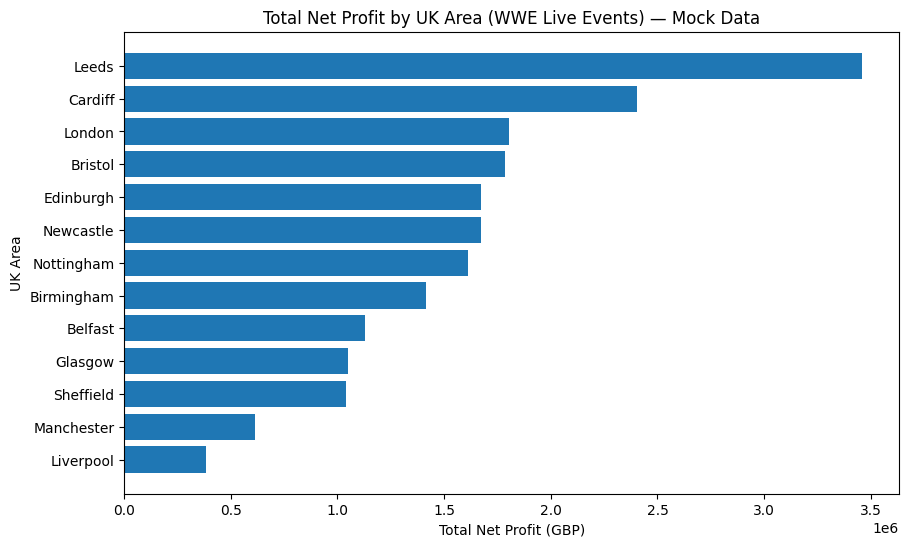

In [9]:
plot_df = area_scorecard.sort_values("total_profit_gbp", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(plot_df["area"], plot_df["total_profit_gbp"])
plt.title("Total Net Profit by UK Area (WWE Live Events) — Mock Data")
plt.xlabel("Total Net Profit (GBP)")
plt.ylabel("UK Area")
plt.show()


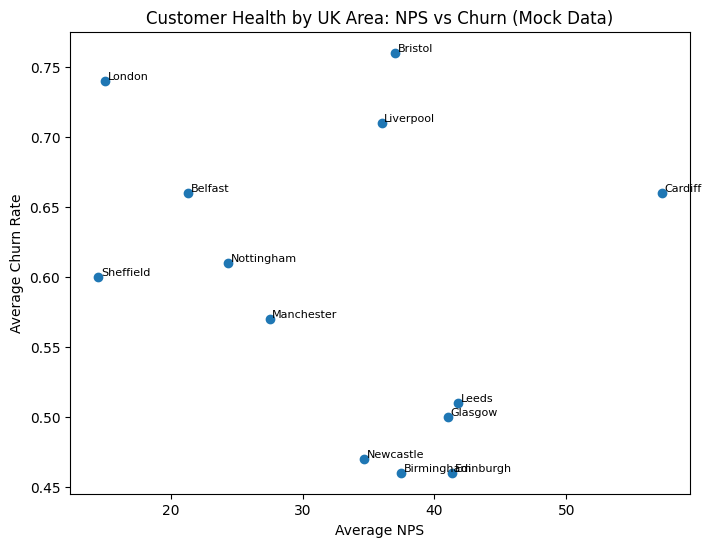

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(area_scorecard["avg_nps"], area_scorecard["avg_churn"])

for _, r in area_scorecard.iterrows():
    plt.text(r["avg_nps"]+0.2, r["avg_churn"]+0.001, r["area"], fontsize=8)

plt.title("Customer Health by UK Area: NPS vs Churn (Mock Data)")
plt.xlabel("Average NPS")
plt.ylabel("Average Churn Rate")
plt.show()


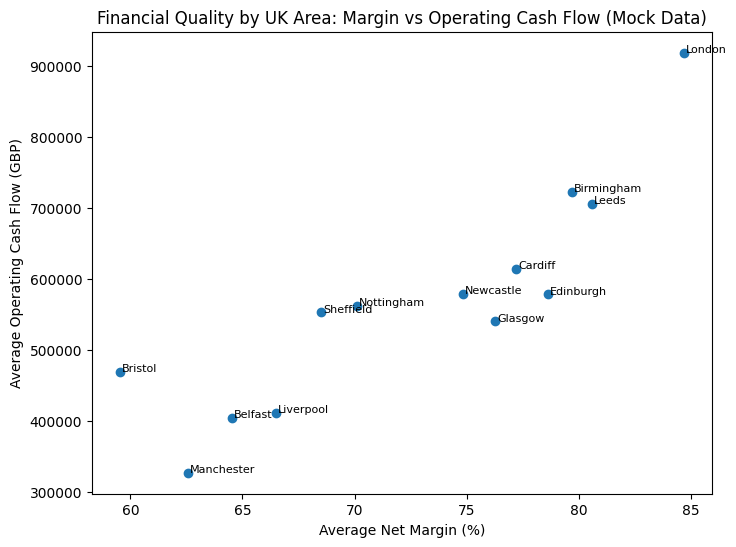

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(area_scorecard["avg_margin_pct"], area_scorecard["avg_cash_flow_gbp"])

for _, r in area_scorecard.iterrows():
    plt.text(r["avg_margin_pct"]+0.1, r["avg_cash_flow_gbp"]+200, r["area"], fontsize=8)

plt.title("Financial Quality by UK Area: Margin vs Operating Cash Flow (Mock Data)")
plt.xlabel("Average Net Margin (%)")
plt.ylabel("Average Operating Cash Flow (GBP)")
plt.show()


In [12]:
rank_df = area_scorecard.copy()

# Choose KPIs to include in the index
# Positive direction: higher is better (profit, margin, cash flow, current ratio, nps, brand, uvp, engagement, on-time)
# Negative direction: lower is better (churn, turnover, cost per attendee)
positive_cols = ["total_profit_gbp","avg_margin_pct","avg_cash_flow_gbp","avg_current_ratio","avg_nps","avg_brand","avg_uvp","avg_engagement","avg_on_time"]
negative_cols = ["avg_churn","avg_turnover","avg_cost_per_attendee"]

def zscore(s):
    s = s.astype(float)
    return (s - s.mean()) / (s.std(ddof=0) + 1e-9)

for c in positive_cols:
    rank_df[c+"_z"] = zscore(rank_df[c])

for c in negative_cols:
    rank_df[c+"_z"] = -zscore(rank_df[c])  # invert so higher is better

rank_df["business_health_index"] = rank_df[[c+"_z" for c in positive_cols + negative_cols]].mean(axis=1)
rank_df = rank_df.sort_values("business_health_index", ascending=False)

rank_df[["area","region","events","total_revenue_gbp","total_profit_gbp","avg_nps","avg_churn","avg_margin_pct","avg_cash_flow_gbp","business_health_index"]].head(15)


,area,region,events,total_revenue_gbp,total_profit_gbp,avg_nps,avg_churn,avg_margin_pct,avg_cash_flow_gbp,business_health_index
6,Leeds,England,5,4252399.32,3459813.32,41.800000,0.51,80.58,706284.0,0.453646
4,Edinburgh,Scotland,3,2096130.32,1672764.32,41.333333,0.46,78.62,578387.0,0.431439
10,Newcastle,England,3,2203683.27,1670729.27,34.666667,0.47,74.83,579108.0,0.404379
3,Cardiff,Wales,4,3092279.62,2402786.62,57.250000,0.66,77.22,614385.0,0.390136
1,Birmingham,England,2,1725693.58,1416028.58,37.500000,0.46,79.68,723336.0,0.232028
5,Glasgow,Scotland,2,1373135.56,1050164.56,41.000000,0.50,76.28,540342.0,0.052983
11,Nottingham,England,3,2282294.90,1612677.90,24.333333,0.61,70.11,562393.0,0.045155
8,London,England,2,2131038.40,1804666.40,15.000000,0.74,84.68,919173.0,0.035222
9,Manchester,England,2,944533.36,615573.36,27.500000,0.57,62.56,326637.0,-0.089956
0,Belfast,Northern Ireland,3,1695851.04,1131069.04,21.333333,0.66,64.52,404233.0,-0.326815
